First let's fit our supernova synthetic data from last time using GPR.
- The key ingredient in getting a good GPR fit is the choice of the kernel and its parameters.
- Check out what's available in the `kernels` submodule of [sklearn.gaussian_process]
- *Hint*. Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

*Note*. We have time constraints, so feel free to tweak the hyperparameters manually while in class. But, of course, a publication-quality result will require a cross-validation analysis. (Do this at home before the exam?)

We now have a suite of **data-driven** predictive models for our supernova dataset (from polynomials to GPR). That is: we can faithfully predict how a future redshift/distance measurement will look like given the current sample.

This is already great and these kind of tools are immensely useful in a variety of contexts (also involving a lot of money: suppose you want to predict how much a give financial asset will perform on tomorrow's stock market... You  might not really care about expressing the underlying financial model in simple terms, as long as your investments are profitable).

For the case of supernovae, however, we have do have physical theory which is $\Lambda$CDM. We can do a **parametric** fit (and hopehully by now the difference between "parametric" and "data driven" fit is clear in your head)

In [18]:
import numpy as np
from matplotlib import pyplot as plt


(35.0, 50.0)

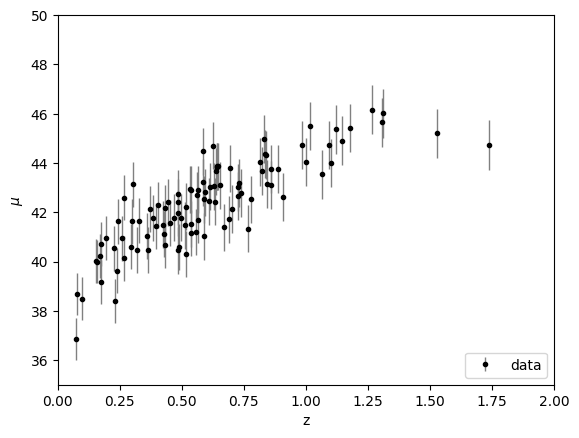

In [19]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

In [20]:
z_sample = z_sample[:,np.newaxis]
x_grid = np.linspace(0, 2, 1000)[:,np.newaxis]

se ho gli errori, imposto alpha con dmu^2 ovvero la varianza, il quadrato della deviazione standard. se non ho gli errori, o imposto alpha piccolo e poi vedo, oppure aggiungo rumore ad esempio con un white noise kernel.

Ecco una spiegazione dettagliata dei parametri **`n_restarts_optimizer`** e **`normalize_y`** utilizzati nel tuo modello **`GaussianProcessRegressor`**:

---

### **`n_restarts_optimizer`**
- **Significato**: Questo parametro specifica il numero di volte in cui l'ottimizzatore dei parametri del kernel viene riavviato con valori iniziali casuali.
- **Contesto**: Durante il fitting del modello, il processo gaussiano ottimizza i parametri del kernel (ad esempio, lunghezza di scala, varianza, ecc.) massimizzando la **log-likelihood marginale**. Tuttavia, questa ottimizzazione può essere complicata perché la funzione di log-likelihood può avere più minimi locali.
- **Scopo**: Aumentare il numero di riavvii consente di esplorare meglio lo spazio dei parametri e ridurre il rischio di rimanere bloccati in un minimo locale.

  **Esempio**:
  ```python
  gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
  ```
  Qui, l'ottimizzatore verrà riavviato 10 volte con valori iniziali casuali per trovare i migliori parametri del kernel.

- **Valori consigliati**:
  - **Basso numero di riavvii (es. 0-2)**: Se il kernel è semplice o i dati sono ben comportati.
  - **Alto numero di riavvii (es. 5-20)**: Se il kernel è complesso o i dati sono rumorosi, per migliorare la robustezza.

---

### **`normalize_y`**
- **Significato**: Questo parametro indica se i dati di output \( y \) (nel tuo caso, `mu_sample`) devono essere normalizzati prima del fitting.
- **Cosa fa**:
  - Se impostato su `True`, il modello sottrae la media di \( y \) e la scala alla varianza unitaria prima di eseguire il fitting.
  - Dopo il fitting, i risultati vengono riportati alla scala originale.

- **Scopo**: La normalizzazione può migliorare la stabilità numerica e le prestazioni dell'ottimizzazione, specialmente quando i valori di \( y \) hanno scale molto diverse o grandi offset.

  **Esempio**:
  ```python
  gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
  ```
  Qui, i dati di output \( y \) verranno normalizzati automaticamente.

- **Quando usarlo**:
  - **`normalize_y=True`**: Se i dati di output hanno un grande offset o una scala non uniforme.
  - **`normalize_y=False`**: Se i dati sono già centrati e scalati o se vuoi mantenere il modello nella scala originale.

---

### **In sintesi**
- **`n_restarts_optimizer`**: Aiuta a trovare i migliori parametri del kernel evitando minimi locali durante l'ottimizzazione.
- **`normalize_y`**: Normalizza i dati di output per migliorare la stabilità numerica e le prestazioni del modello.

Nel tuo caso:
```python
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=dmu**2, normalize_y=True)
```
- **`n_restarts_optimizer=10`**: Riavvia l'ottimizzatore 10 volte per trovare i migliori parametri del kernel.
- **`normalize_y=True`**: Normalizza i valori di `mu_sample` per migliorare la stabilità numerica.

In [21]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


kernel = RBF(1.0, (1e-2, 1e2))

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=dmu**2, normalize_y=True)


aggiungo commenti e un sacco di cose 

(35.0, 50.0)

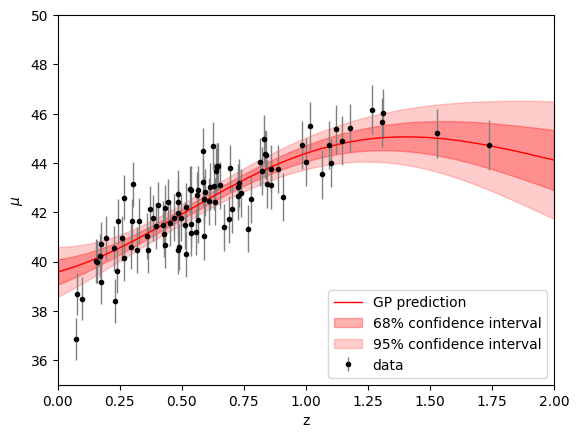

In [22]:
gp.fit(z_sample, mu_sample)
mu_pred, dmu_pred = gp.predict(x_grid, return_std=True)
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(x_grid, mu_pred, 'r-', lw=1, label='GP prediction')

plt.fill_between(x_grid[:, 0], mu_pred - dmu_pred, mu_pred + dmu_pred, alpha=0.3, color='r', label='68% confidence interval')

plt.fill_between(x_grid[:,0], mu_pred - 1.96*dmu_pred, mu_pred + 1.96*dmu_pred, alpha=0.2, color='r', label='95% confidence interval')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)



questo è un primo tentativo solo con RBF, ora provo a sommarci una C

(35.0, 50.0)

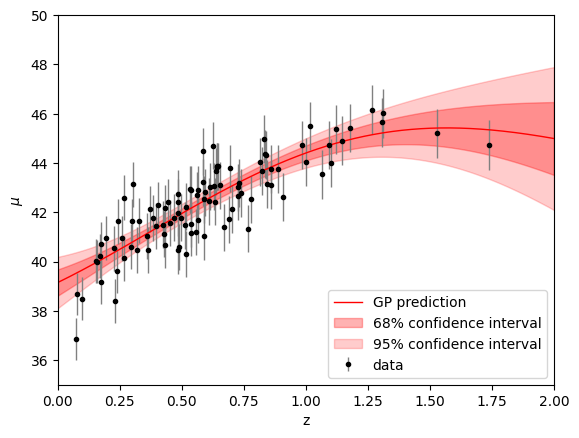

In [23]:
kernel = C(1.0, (1e-2, 1e2)) * RBF(1.0, (1e-2, 1e2))

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=dmu**2, normalize_y=True)

gp.fit(z_sample, mu_sample)
mu_pred, dmu_pred = gp.predict(x_grid, return_std=True)
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(x_grid, mu_pred, 'r-', lw=1, label='GP prediction')

plt.fill_between(x_grid[:, 0], mu_pred - dmu_pred, mu_pred + dmu_pred, alpha=0.3, color='r', label='68% confidence interval')
plt.fill_between(x_grid[:,0], mu_pred - 1.96*dmu_pred, mu_pred + 1.96*dmu_pred, alpha=0.2, color='r', label='95% confidence interval')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)


ora provo un ultimo kernel, il Matern 5/2

(35.0, 50.0)

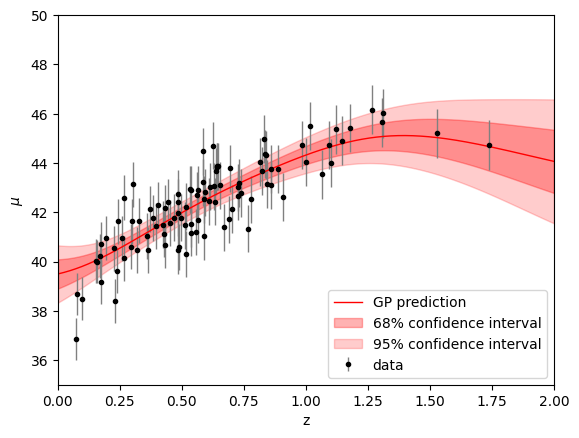

In [24]:
from sklearn.gaussian_process.kernels import Matern

kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=2.5)

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=dmu**2, normalize_y=True)
gp.fit(z_sample, mu_sample)
mu_pred, dmu_pred = gp.predict(x_grid, return_std=True)
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(x_grid, mu_pred, 'r-', lw=1, label='GP prediction')

plt.fill_between(x_grid[:, 0], mu_pred - dmu_pred, mu_pred + dmu_pred, alpha=0.3, color='r', label='68% confidence interval')
plt.fill_between(x_grid[:,0], mu_pred - 1.96*dmu_pred, mu_pred + 1.96*dmu_pred, alpha=0.2, color='r', label='95% confidence interval')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)


(35.0, 50.0)

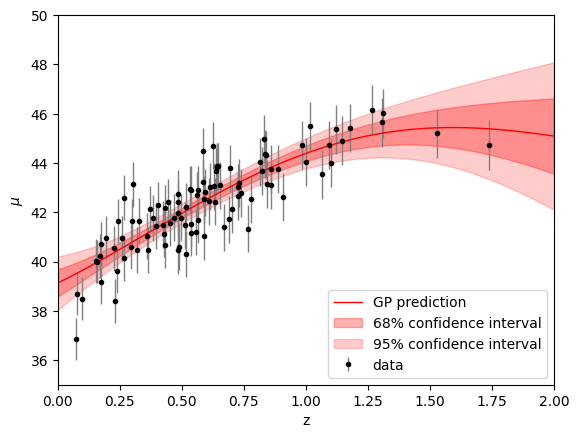

In [25]:
kernel = C(1.0, (1e-2, 1e2)) * (Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=2.5) + RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=dmu**2, normalize_y=True)
gp.fit(z_sample, mu_sample)
mu_pred, dmu_pred = gp.predict(x_grid, return_std=True)
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(x_grid, mu_pred, 'r-', lw=1, label='GP prediction')

plt.fill_between(x_grid[:, 0], mu_pred - dmu_pred, mu_pred + dmu_pred, alpha=0.3, color='r', label='68% confidence interval')

plt.fill_between(x_grid[:,0], mu_pred - 1.96*dmu_pred, mu_pred + 1.96*dmu_pred, alpha=0.2, color='r', label='95% confidence interval')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

LI ANALIZZO e li metto tutti in un unico plot magari così esce più ordinato, li paragono  anche.

OTTIMIZZO CON SKIT LEARN E TROVO I PARAMETRI MIGLIORI CON CROSS VALIDATION

ci sono poi una marea di cose da fare che non ho fatto perchè sono delle volte scorse